#Sematic Segmentation on LandCover.ai: Dataset

The dataset and some instructions have been taken from the following paper:

Paper Link: https://arxiv.org/abs/2005.02264v3

We will use Unet as basic network for image segmentation

#Loading data

##Loading a single orignal image and it's mask:

In [1]:
#Importing some essential Libraries:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imageio
import torchvision.transforms.functional as F
import torch.nn.functional as F1

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


Loading the above data and using orignal images for training takes a lot of RAM space which is not feasible. <br>
classes: building (1), woodland (2), water(3), road(4), background(0)

In [4]:
image_path = '/content/drive/MyDrive/DL/Landcover/images'

image_data = []
image_masks = []

#Loading Images
print("Loading Training Images...")
filenames = [os.path.join(image_path, img) for img in os.listdir(image_path)]
filenames.sort()
i = 0
for img in filenames:
  image_arr = cv2.imread(img)  #One image of dim (W, H, 3)

  #Resizing
  #new_image = cv2.resize(image_arr, (240,240))   
  new_image = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB)
  image_data.append(new_image)
  i +=1
  if i >=1:
    break

images = np.array(image_data)


#Loading Masks
image_mask_path = '/content/drive/MyDrive/DL/Landcover/masks'
print("Loading Training Masks...")
filenames = [os.path.join(image_mask_path, img) for img in os.listdir(image_mask_path)]
filenames.sort()

i=0
for img in filenames:
  image_arr = imageio.imread(img)  #One image of dim (W, H, 3)
  
  #Resizing
  #new_image = cv2.resize(image_arr, (240,240))  
  image_masks.append(image_arr)
  i +=1
  if i >=1:
    break

  
images = np.array(image_data)
masks = np.array(image_masks)

print("Training images shape: " ,images.shape)     
print("Training Masks shape: ",masks.shape)      #Labels are grayscale Images

Loading Training Images...
Loading Training Masks...
Training images shape:  (1, 9711, 9081, 3)
Training Masks shape:  (1, 9711, 9081)


##Visualizing one orignal Image
 

Image


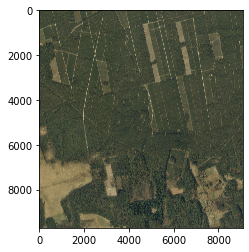

It's Mask
range of values for the masks:  [0 1 2 4]


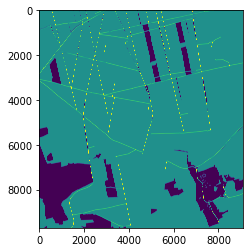

In [5]:
plt.figure(1)
print("Image")
plt.imshow(images[0])
plt.show()
plt.figure(2)
print("It's Mask")
ranges = np.unique(masks)
print("range of values for the masks: ", ranges)
plt.imshow(masks[0])
plt.show()

In [6]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Thus we can see that we have to segment our pixels into five classes. They are:  building (1), woodland (2), water(3), road(4), background(0)

The no of pixels are very high thus we cannot use orignal images to train the model. So we will divide our orignal image into smallar smallar images by cropping the images of fixed sizes. We will try not to loose too many pixels during this process.

##Loading the data and performing above operations

In [7]:
from PIL import Image
from patchify import patchify

patch_size = 240
image_list = []
mask_list = []

#Loading, cropping images and storing them in numpy arrays
print("Loading Training Images...")

img_dir=  '/content/drive/MyDrive/DL/Landcover/images'

filenames = [os.path.join(img_dir, img) for img in os.listdir(img_dir)]
filenames.sort()

for img in filenames:
            
  image = cv2.imread(img, 1)  #Read each image as BGR
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  SIZE_X = (image.shape[1]//patch_size)*patch_size 
  SIZE_Y = (image.shape[0]//patch_size)*patch_size 
  image = Image.fromarray(image)
  image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
  image = np.array(image)             
  
  patches_img = patchify(image, (240, 240, 3), step=240)  
  #print(patches_img.shape)
            
  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      #m = (patches_img[i,j,:,:,:,:].reshape(patches_img.shape[3], patches_img.shape[4], patches_img.shape[5]))
      #if  (m.size - np.count_nonzero(m)) / m.size < 0.1:                      #Removing those images which mostly has background in it.
      image_list.append(patches_img[i,j,:,:,:,:].reshape(patches_img.shape[3], patches_img.shape[4], patches_img.shape[5]))


images = np.array(image_list)
#print("Training images shape: " ,images.shape) 
#Loading Training Masks
print("Loading Training Masks...")

mask_dir=  '/content/drive/MyDrive/DL/Landcover/masks'

filenames = [os.path.join(mask_dir, img) for img in os.listdir(mask_dir)]
filenames.sort()

for img in filenames:
         
  mask = cv2.imread(img, 0)  #Read each image as Greyscale
  SIZE_X = (mask.shape[1]//patch_size)*patch_size 
  SIZE_Y = (mask.shape[0]//patch_size)*patch_size 
  mask = Image.fromarray(mask)
  mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop the image from top left corner
  mask = np.array(mask)             
  
  patches_mask = patchify(mask, (240, 240), step=240) 
  #print(patches_mask.shape)
  for i in range(patches_mask.shape[0]):
    for j in range(patches_mask.shape[1]):
      #m = patches_mask[i,j, :, :]
      #if  (m.size - np.count_nonzero(m)) / m.size < 0.1:
      mask_list.append(patches_mask[i,j, :, :])


masks = np.array(mask_list)

print("Training images shape: " ,images.shape)     
print("Training Masks shape: ",masks.shape)


Loading Training Images...
Loading Training Masks...
Training images shape:  (2960, 240, 240, 3)
Training Masks shape:  (2960, 240, 240)


##Visulaizing the image and it's mask

Image


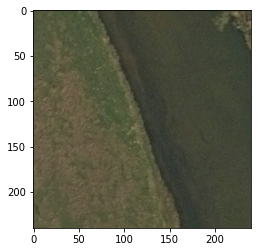

It's Mask
range of values for the masks:  [0 2 3]


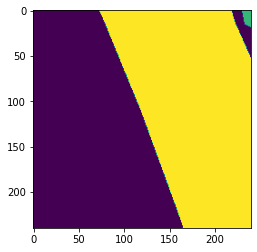

In [8]:
idx = 1529
plt.figure(1)
print("Image")
plt.imshow(images[idx])
plt.show()
plt.figure(2)
print("It's Mask")
ranges = np.unique(masks[idx])
print("range of values for the masks: ", ranges)
plt.imshow(masks[idx])
plt.show()

In [9]:
#Loading takes time thus saving the numpy array to load faster in the futrue
img_save = '/content/drive/MyDrive/DL/Landcover'
file_path_save = 'images_land.npy'
np.save(os.path.join(img_save, file_path_save), images)

file_path_save = 'masks_land.npy'
np.save(os.path.join(img_save, file_path_save), masks)

In [10]:
images = np.load(os.path.join(img_save,'images_land.npy' ))
masks = np.load(os.path.join(img_save,'masks_land.npy' ))

print("Shape of loaded images: ",images.shape)
print("Shape of loaded masks: ",masks.shape)

Shape of loaded images:  (2960, 240, 240, 3)
Shape of loaded masks:  (2960, 240, 240)


Checking if GPU is available

In [11]:
if torch.cuda.is_available():
  print("cuda GPU is available")
  DEVICE = 'cuda'
else:
  print("GPU is not available")
  DEVICE = 'cpu'

cuda GPU is available


Transferring the images to the device

In [12]:
images = torch.tensor(images[0:200], device = DEVICE, dtype = torch.float32)
masks = torch.tensor(masks[0:200], device = DEVICE, dtype = torch.int64)

In [13]:
#changing image dimension to that which is accepted by the the model
images = images.permute(0,3,1,2)

#Operations required to calculate the loss

In [14]:
maskoh = F1.one_hot(masks, num_classes=5)

In [15]:
print("shape of one hot encoded masks: ", maskoh.shape)

shape of one hot encoded masks:  torch.Size([200, 240, 240, 5])


In [16]:
maskoh = maskoh.permute(0,3,1,2)

In [17]:
print(maskoh.shape)

torch.Size([200, 5, 240, 240])


#Creating Unet architecture

In [31]:
class unet(nn.Module):

  def __init__(self, in_channels, out_channels, features):     #Features is the dimension of Height and Width of the image
    super(unet, self).__init__()
    self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv5 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, 1, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, 3, 1, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
        )

    #upsampling layers
    self.up1 = nn.ConvTranspose2d( 1024, 512, kernel_size=2, stride=2, )
    self.conv6 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
    
    self.up2 = nn.ConvTranspose2d( 512, 256, kernel_size=2, stride=2, )
    self.conv7 = nn.Sequential(
            nn.Conv2d(512, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
    
    self.up3 = nn.ConvTranspose2d( 256, 128, kernel_size=2, stride=2, )
    self.conv8 = nn.Sequential(
            nn.Conv2d(256, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
    
    self.up4 = nn.ConvTranspose2d( 128, 64, kernel_size=2, stride=2, )
    self.conv9 = nn.Sequential(
            nn.Conv2d(128, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
    self.conv_final = nn.Conv2d(64, out_channels, 3, 1, 1)               #output channel is the no of classes
    
  def forward(self, input):

    #Downsampling Part
    out = self.conv1(input)
    out_1 = out
    out = self.pool1(out)       #()

    out = self.conv2(out)
    out_2 = out
    out = self.pool2(out)

    out = self.conv3(out)
    out_3 = out
    out = self.pool3(out)
    
    out = self.conv4(out)
    out_4 = out
    out = self.pool4(out)
    
    out = self.conv5(out)
    
    #Upsampling part
    out = self.up1(out)    
    out = torch.cat((out_4, out), dim = 1)
    out = self.conv6(out)

    out = self.up2(out)     
    out = torch.cat((out_3, out), dim = 1)
    out = self.conv7(out)

    out = self.up3(out)     
    out = torch.cat((out_2, out), dim = 1)
    out = self.conv8(out)

    out = self.up4(out)     
    out = torch.cat((out_1, out), dim = 1)
    out = self.conv9(out)

    out = self.conv_final(out)

    return out

    #Using transpose convolutions insted of Bilinear interpolation used in orignal paper




In [32]:
model = unet(3, 5, 280).to(device = DEVICE)

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
loss_type = torch.nn.CrossEntropyLoss()
step_lr = lr_scheduler.StepLR(optimizer, step_size= 300, gamma = 0.75)   #Every 50 epochs our learning rate will be multiplied by gamma

In [34]:
#Model Training
loss_graph = []
num_epochs = 1000
num_train = images.shape[0]
batch_size = 20
gamma = 0.1
for i in range(num_epochs):
  random_no = torch.randint(0, num_train, (batch_size,))
  x_batch = images[random_no]
  y_batch = masks[random_no]

  model.train()
  optimizer.zero_grad()
  y_pred = model(x_batch)

  y_pred = y_pred.permute(0,2,3,1)
  
  y_pred = y_pred.reshape(-1, 5)

  y_batch = y_batch.reshape(-1)

  loss = loss_type(y_pred, y_batch)
  loss_exp = torch.exp(-loss)
  focal_loss = ((1-loss_exp)**gamma)*loss
  focal_loss.backward()                                #Using focal loss as the dataset has imbalance
  optimizer.step()
  step_lr.step()
  loss_graph.append(loss.cpu().item())
  if i%10==0:
    print("Epoch: ", i, ", loss is: ", loss.cpu().item())

Epoch:  0 , loss is:  1.669377088546753
Epoch:  10 , loss is:  1.5946190357208252
Epoch:  20 , loss is:  1.5139381885528564
Epoch:  30 , loss is:  1.464133381843567
Epoch:  40 , loss is:  1.3734619617462158
Epoch:  50 , loss is:  1.3021117448806763
Epoch:  60 , loss is:  1.3275494575500488
Epoch:  70 , loss is:  1.2193207740783691
Epoch:  80 , loss is:  1.1554961204528809
Epoch:  90 , loss is:  1.18691885471344
Epoch:  100 , loss is:  1.0827170610427856
Epoch:  110 , loss is:  1.0154725313186646
Epoch:  120 , loss is:  1.0075860023498535
Epoch:  130 , loss is:  1.012714147567749
Epoch:  140 , loss is:  0.9178252816200256
Epoch:  150 , loss is:  0.8844236731529236
Epoch:  160 , loss is:  0.9380025863647461
Epoch:  170 , loss is:  0.8999513983726501
Epoch:  180 , loss is:  0.8125284314155579
Epoch:  190 , loss is:  0.817436695098877
Epoch:  200 , loss is:  0.756034791469574
Epoch:  210 , loss is:  0.7227995991706848
Epoch:  220 , loss is:  0.7261698246002197
Epoch:  230 , loss is:  0.777

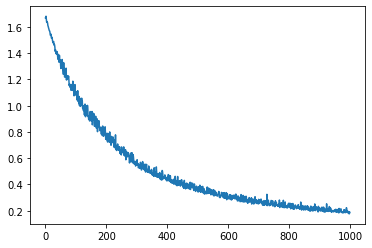

In [35]:
plt.plot(loss_graph)

torch.Size([1, 5, 240, 240])

Image


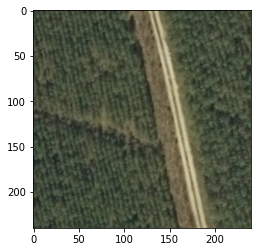


Predicted segmentation channel for one of the mask


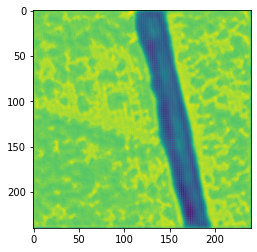


Actual mask


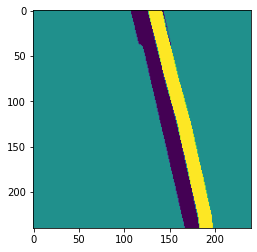

Actual classes:  [0 2 4]


In [36]:
idx = 170

y = model(images[idx].reshape(1,images.shape[1], images.shape[2], images.shape[3]))
print(y.shape)
plt.figure(2)
print("\nImage")
plt.imshow((images[idx]/255.0).permute(1,2,0).detach().cpu().numpy())
plt.show()
plt.figure(3)
print("\nPredicted segmentation channel for one of the mask")
plt.imshow(np.array(y.reshape(5,240,240)[2].detach().cpu().numpy()))
plt.show()

plt.figure(4)
print("\nActual mask")
plt.imshow(np.array(masks[idx].clone().cpu()))
plt.show()

print("Actual classes: ", np.unique(masks[150].cpu()))

##Displaying the predicted classes:

In [37]:
y = y.reshape(y.shape[1], y.shape[2], y.shape[3])


In [38]:
output = torch.argmax(y,axis = 0)
print(output.shape)

torch.Size([240, 240])


Predicted classes


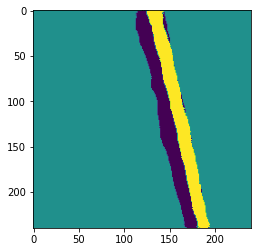

predicted classes: (The model predicts these classes for the given image)  [0 2 3 4]


In [39]:
print("Predicted classes")
plt.imshow(np.array(output.clone().cpu()))
plt.show()

print("predicted classes: (The model predicts these classes for the given image) ", np.unique(output.cpu()))
